# Project Overview

This notebook displays the gender distributions and age ranges of subjects in and XNAT project. The gender and age of each subject is retrieved with [XNATpy](https://xnat.readthedocs.io/en/latest/). 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import xnat
import ipywidgets as widgets
import numpy as np
import pydicom
import re
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
if os.environ['XNAT_XSI_TYPE'] != 'xnat:projectData':
    raise Exception('Must be started from an XNAT project.')

project_id = os.environ['XNAT_ITEM_ID']

In [3]:
connection = xnat.connect()
project = connection.projects[project_id]

In [4]:
print(f"XNAT Project: {project.name}")
print(f"Project Description: {project.description}")
print(f"Subject count: {len(project.subjects)}")
print(f"Experiment count: {len(project.experiments)}")

XNAT Project: C4KC-KiTS
Project Description: This collection contains CT scans and segmentations from subjects from the training set of the 2019 Kidney and Kidney Tumor Segmentation Challenge (KiTS19). The challenge aimed to accelerate progress in automatic 3D semantic segmentation by releasing a dataset of CT scans for 210 patients with manual semantic segmentations of the kidneys and tumors in the corticomedullary phase.
Subject count: 210
Experiment count: 4


In [5]:
subject_data = {
    'id': [],
    'gender': [],
    'age': []
}

for subject in project.subjects.values():
    subject_data['id'].append(subject.label)
    subject_data['gender'].append(subject.demographics.gender)
    subject_data['age'].append(subject.demographics.age)
    
df = pd.DataFrame(subject_data)

## Subject Data

In [6]:
df

,id,gender,age
0,KiTS-00000,male,49
1,KiTS-00001,male,50
2,KiTS-00002,male,74
3,KiTS-00003,female,44
4,KiTS-00004,male,73
...,...,...,...
205,KiTS-00194,male,73
206,KiTS-00197,male,84
207,KiTS-00198,male,79
208,KiTS-00203,female,81


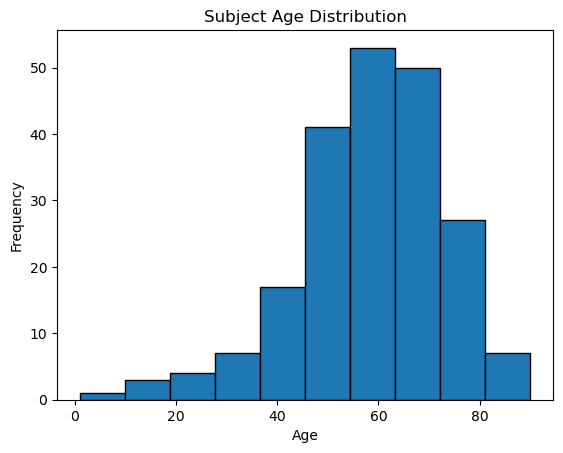

In [7]:
ages = df['age']

# Create the histogram
plt.hist(ages, bins=10, edgecolor='black')

# Set the labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Subject Age Distribution')

# Display the histogram
plt.show()

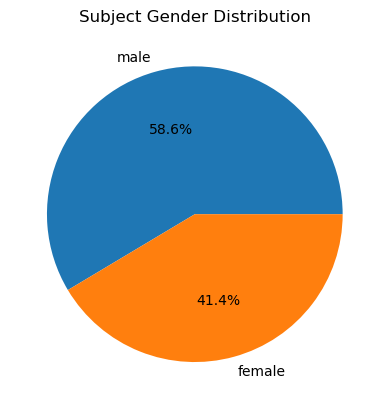

In [8]:
genders = df['gender'].value_counts()

# Create the pie chart
plt.pie(genders, labels=genders.index, autopct='%1.1f%%')

# Set the title
plt.title('Subject Gender Distribution')

# Display the pie chart
plt.show()


## View image sessions
Select an image session.

In [9]:
session_labels = ['']
session_labels.extend([session.label for session in project.experiments.values()])
dd=widgets.Dropdown(
    options=session_labels,
    description='Session:',
    disabled=False,
)

@interact(session=dd, rows=(2,5), cols=(2,5), invert=False)
def plot_dicom_images(session, rows=2, cols=4, invert=False):
    if not session or session == '':
        print('No session selected')
        return
    
    scan = project.experiments[session].scans[0]
    
    file_list = list(filter(lambda k: k.endswith('.dcm'), list(scan.files)))
    file_list.sort(key=lambda k: pydicom.dcmread(scan.files[k].open()).InstanceNumber)
    
    num_scans = min(rows * cols, len(file_list))
    figsize = (cols * 3, rows * 3)

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.01, hspace=0.01)  # Adjust subplot spacing

    for i, j in zip(range(num_scans), np.linspace(0, len(file_list) - 1, num=num_scans)):
        file = file_list[int(j)]
        ds = pydicom.dcmread(scan.files[file].open())

        image = ds.pixel_array
        if invert:
            image = np.max(image) - image  # Invert the image

        row = i // cols
        col = i % cols

        axs[row, col].imshow(image, cmap=plt.cm.gray)
        axs[row, col].axis('off')  # Hide axis labels and ticks

    plt.show()

interactive(children=(Dropdown(description='Session:', options=('', 'KiTS-00001-CT-49621', 'KiTS-00002-CT-0792…